<a href="https://colab.research.google.com/github/Belvinbarasa/Eng.barasa/blob/main/Robot_Navigation_using_Deep_Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
!pip install gym
!pip install matplotlib
!pip install tqdm


In [ ]:
# Import libraries
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
# Create a simple environment
class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=5):
        super(GridWorldEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = gym.spaces.Discrete(4)  # 0:up, 1:down, 2:left, 3:right
        self.observation_space = gym.spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        self.reset()

    def reset(self):
        self.agent_pos = np.array([0, 0])
        self.goal_pos = np.array([self.grid_size-1, self.grid_size-1])
        return self.agent_pos.copy()

    def step(self, action):
        if action == 0 and self.agent_pos[0] > 0:  # up
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[0] < self.grid_size - 1:  # down
            self.agent_pos[0] += 1
        elif action == 2 and self.agent_pos[1] > 0:  # left
            self.agent_pos[1] -= 1
        elif action == 3 and self.agent_pos[1] < self.grid_size - 1:  # right
            self.agent_pos[1] += 1

        done = np.array_equal(self.agent_pos, self.goal_pos)
        reward = 10 if done else -1

        return self.agent_pos.copy(), reward, done, {}

    def render(self, mode='human'):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        grid[self.goal_pos[0], self.goal_pos[1]] = 'G'
        grid[self.agent_pos[0], self.agent_pos[1]] = 'A'
        print("\n".join([" ".join(row) for row in grid]))
        print()

# Test the environment
env = GridWorldEnv(grid_size=5)
env.render()


A . . . .
. . . . .
. . . . .
. . . . .
. . . . G



In [ ]:
# Build a simple neural network for Q-Learning
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
# Hyperparameters
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 500
LR = 1e-3
BATCH_SIZE = 64
TARGET_UPDATE = 10
MEMORY_SIZE = 10000
NUM_EPISODES = 300

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Epsilon greedy action selection
def select_action(state, policy_net, steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()
    else:
        return random.randrange(env.action_space.n)


In [ ]:
# Initialize environment and networks
env = GridWorldEnv(grid_size=5)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0
episode_rewards = []

# Training
for episode in tqdm(range(NUM_EPISODES)):
    state = env.reset()
    total_reward = 0
    for t in range(100):
        action = select_action(state, policy_net, steps_done)
        next_state, reward, done, _ = env.step(action)
        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        steps_done += 1

        # Training step
        if len(memory) >= BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

            batch_state = torch.FloatTensor(batch_state).to(device)
            batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
            batch_next_state = torch.FloatTensor(batch_next_state).to(device)
            batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

            q_values = policy_net(batch_state).gather(1, batch_action)
            next_q_values = target_net(batch_next_state).max(1)[0].detach().unsqueeze(1)
            expected_q_values = batch_reward + (GAMMA * next_q_values * (1 - batch_done))

            loss = nn.MSELoss()(q_values, expected_q_values)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    episode_rewards.append(total_reward)

    # Update target network
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print("Training Complete!")


  0%|          | 0/300 [00:00<?, ?it/s]<ipython-input-6-c8cd2dccbd4f>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch_state = torch.FloatTensor(batch_state).to(device)
100%|██████████| 300/300 [00:33<00:00,  8.94it/s]

Training Complete!


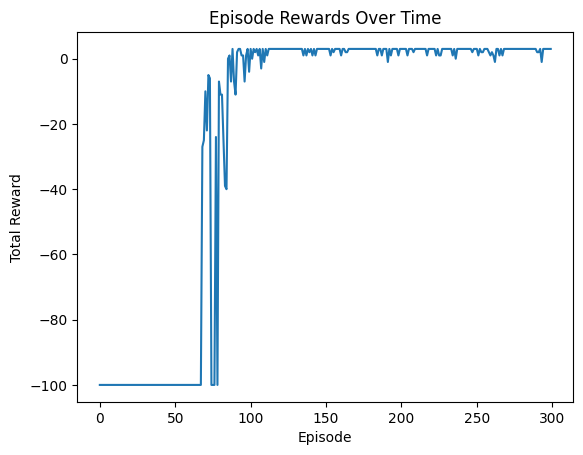

In [ ]:
# Plot rewards
plt.plot(episode_rewards)
plt.title('Episode Rewards Over Time')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()


In [ ]:
# Test trained agent
state = env.reset()
env.render()
done = False
while not done:
    action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    env.render()


A . . . .
. . . . .
. . . . .
. . . . .
. . . . G

. . . . .
A . . . .
. . . . .
. . . . .
. . . . G

. . . . .
. A . . .
. . . . .
. . . . .
. . . . G

. . . . .
. . A . .
. . . . .
. . . . .
. . . . G

. . . . .
. . . . .
. . A . .
. . . . .
. . . . G

. . . . .
. . . . .
. . . . .
. . A . .
. . . . G

. . . . .
. . . . .
. . . . .
. . . A .
. . . . G

. . . . .
. . . . .
. . . . .
. . . . A
. . . . G

. . . . .
. . . . .
. . . . .
. . . . .
. . . . A



In [ ]:
# Test trained agent
state = env.reset()
env.render()
done = False
while not done:
    action = policy_net(torch.FloatTensor(state).unsqueeze(0).to(device)).max(1)[1].item()
    next_state, reward, done, _ = env.step(action)
    state = next_state
    env.render()


A . . . .
. . . . .
. . . . .
. . . . .
. . . . G

. . . . .
A . . . .
. . . . .
. . . . .
. . . . G

. . . . .
. A . . .
. . . . .
. . . . .
. . . . G

. . . . .
. . A . .
. . . . .
. . . . .
. . . . G

. . . . .
. . . . .
. . A . .
. . . . .
. . . . G

. . . . .
. . . . .
. . . . .
. . A . .
. . . . G

. . . . .
. . . . .
. . . . .
. . . A .
. . . . G

. . . . .
. . . . .
. . . . .
. . . . A
. . . . G

. . . . .
. . . . .
. . . . .
. . . . .
. . . . A

